In [1]:
import pyspark
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

appName = "Big Data Analytics"
master = "local"

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master)

sc = SparkContext.getOrCreate(conf=conf)

sqlContext = SQLContext(sc)

spark = sqlContext.sparkSession.builder.getOrCreate()

C:\Users\rishi\anaconda3\lib\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
col_names = ['sofifa_id', 'player_url', 'short_name', 'long_name', 'player_positions', 
    'overall', 'potential', 'value_eur', 'wage_eur', 'age', 'dob', 'height_cm', 
    'weight_kg', 'club_team_id', 'club_name', 'league_name', 'league_level', 
    'club_position', 'club_jersey_number', 'club_loaned_from', 'club_joined', 
    'club_contract_valid_until', 'nationality_id', 'nationality_name', 'nation_team_id', 
    'nation_position', 'nation_jersey_number', 'preferred_foot', 'weak_foot', 'skill_moves', 
    'international_reputation', 'work_rate', 'body_type', 'real_face', 'release_clause_eur', 
    'player_tags', 'player_traits', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 
    'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 
    'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 
    'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 
    'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 
    'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 
    'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 
    'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 
    'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 
    'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 
    'goalkeeping_reflexes', 'goalkeeping_speed', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 
    'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 
    'lcb', 'cb', 'rcb', 'rb', 'gk', 'player_face_url', 'club_logo_url', 'club_flag_url', 
    'nation_logo_url', 'nation_flag_url']

In [3]:
df = spark.read.csv("players_15.csv",header=True, inferSchema= True).toDF(*col_names)
df = df.withColumn("Gender", lit("Male"))
df = df.withColumn("Year", lit("2015"))

In [4]:
for year, file_name in enumerate(["players_16.csv","players_17.csv","players_18.csv","players_19.csv","players_20.csv","players_21.csv","players_22.csv"]):
    year = year + 2016
    df_new = spark.read.csv(file_name,header=True, inferSchema= True).toDF(*col_names)
    df_new = df_new.withColumn("Gender", lit("Male"))
    df_new = df_new.withColumn("Year", lit(year))
    df = df.union(df_new)

In [5]:
df_females = spark.read.csv("female_players_16.csv",header=True, inferSchema= True).toDF(*col_names)
df_females = df_females.withColumn("Gender", lit("Female"))
df_females = df_females.withColumn("Year", lit("2016"))

In [6]:
#Repeating the same step for females: 
for year, file_name in enumerate(['female_players_17.csv','female_players_18.csv','female_players_19.csv', 'female_players_20.csv',  'female_players_21.csv', 'female_players_22.csv']):
    year = year + 2017
    df_new = spark.read.csv(file_name,header=True, inferSchema= True).toDF(*col_names)
    df_new = df_new.withColumn("Gender", lit("Female"))
    df_new = df_new.withColumn("Year", lit(year))
    df_females = df_females.union(df_new)

In [7]:
df_all= df.union(df_females) # Fusing the male and female dataframe 

In [8]:
df_all = df_all.withColumn("id", monotonically_increasing_id())
new_column_order = ["id"] + [col for col in df_all.columns if col != "id"]
df_all = df_all.select(new_column_order)
df_all = (df_all.withColumn("Data_Year", df_all["Year"].cast("integer")).drop("Year")) #fixing the datatype for year

In [9]:
df_all.count()

144323

In [10]:
#Defining PostgreSQL

db_properties={}
db_properties['username']="postgres"
db_properties['password']="Pickle1_Juice"
db_properties['url']= "jdbc:postgresql://localhost:5432/project" #C:\Program Files\PostgreSQL\16\data
db_properties['table']="fifa"
db_properties['driver']="org.postgresql.Driver"

In [11]:
# Writing dataframe to PostgresSQl 
df_all.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

In [12]:
df_read = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

In [13]:
df_read.printSchema()

root
 |-- id: long (nullable = true)
 |-- sofifa_id: integer (nullable = true)
 |-- player_url: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- long_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: string (nullable = true)
 |-- wage_eur: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- dob: string (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_team_id: string (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: string (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: string (nullable = true)
 |-- club_loaned_from: string (nullable = true)
 |-- club_joined: string (nullable = true)
 |-- club_contract_valid_until: string (nullable = true)
 |-- nationalit

### Task 2

In [14]:
df_males = df_read.filter((col("Gender") == "Male"))
df_males.count() #Number of males in the dataset

142079

In [15]:
def get_top_clubs(df, year_x, clubs_y, year_z):
    
    if year_x < 2015 or year_x > 2022:
        return "Invalid year X. Please input a value for year X between 2015 and 2022, inclusive."

    if clubs_y <= 0:
        return "Invalid number Y. Please input a positive integer value for Y."

    if year_z < 2023:
        return "Invalid year Z. Please input a value for year Z of 2023 or later."
    
    filtered_df = df.filter((col('Data_Year') == year_x) & (col('club_contract_valid_until') >= year_z))
    
    # Group by 'club', count the players in each club, and order by the count in descending order
    top_clubs_df = filtered_df.groupBy('club_name').agg(count('*').alias('player_count'))\
                              .orderBy(col('player_count').desc())\
                              .limit(clubs_y)
    
    return top_clubs_df.select("club_name").show(truncate = False)

In [16]:
get_top_clubs(df_males,2022,5, 2023)

+------------------------+
|club_name               |
+------------------------+
|Leeds United            |
|Sevilla FC              |
|FC Barcelona            |
|VfB Stuttgart           |
|Borussia Mönchengladbach|
+------------------------+



In [17]:
def list_clubs_by_avg_age(df, year, clubs_X, order='highest'):

    if clubs_X <= 0:
        return 'Invalid number of entries requested. The number should be a positive integer.'
    
    if year <= 0 or year >= 2022:
        return 'Invalid year. Please input a value for year between 2015 and 2022 inlusive.'
    df_filtered = df.filter(col('Data_Year') == year) # Get all clubs in a given year
    club_avg_age = df_filtered.groupBy('club_name').agg(avg('age').alias('avg_age')) # get avg age of each club
    club_avg_age = club_avg_age.withColumn('avg_age', round(col('avg_age'), 2))
    
    if order == 'highest':
        sorted_clubs = club_avg_age.orderBy(col('avg_age').desc())
    elif order == 'lowest':
        sorted_clubs = club_avg_age.orderBy(col('avg_age').asc())
    else:
        return print(" Invalid Function Argument, only 'highest' and 'lowest' accepted lol.")

    top_x_sorted_clubs = sorted_clubs.limit(clubs_X) # limit the list by X
    
    last_club = top_x_sorted_clubs.collect()[-1] # get the entry at end of the limited sorted list
    last_avg_age = last_club['avg_age'] 

    tied_clubs = sorted_clubs.filter(col('avg_age') == last_avg_age)#.select() # get all clubs with avg age tied for last    
    #top_x_sorted_clubs= top_x_sorted_clubs.limit(clubs_X)   
    final_clubs = top_x_sorted_clubs.union(tied_clubs)
    final_clubs = final_clubs.distinct().orderBy('avg_age', ascending=False)
    return final_clubs.select("club_name","avg_age").show(truncate = False)

In [18]:
list_clubs_by_avg_age(df_males, 2016, 3, order = 'highest')

+----------------------------+-------+
|club_name                   |avg_age|
+----------------------------+-------+
|Dorados de Sinaloa          |28.93  |
|Bruk-Bet Termalica Nieciecza|28.23  |
|Chievo Verona               |28.11  |
+----------------------------+-------+



In [19]:
from pyspark.sql import Window
def max_nations(df):
    # Group by year and nationality, count occurrences
    most_common_nationality = df.groupBy("Data_Year", "nationality_name") \
        .count()
    
    # Define a Window specification
    window_spec = Window.partitionBy("Data_Year").orderBy(desc("count"))
    
    # Add rank to the most common nationality
    most_popular_per_year = most_common_nationality \
        .withColumn("rank", row_number().over(window_spec)) \
        .filter(col("rank") == 1) \
        .select("Data_Year", "nationality_name")

    return most_popular_per_year.show()

In [20]:
max_nations(df_males)

+---------+----------------+
|Data_Year|nationality_name|
+---------+----------------+
|     2015|         England|
|     2016|         England|
|     2017|         England|
|     2018|         England|
|     2019|         England|
|     2020|         England|
|     2021|         England|
|     2022|         England|
+---------+----------------+



### Question 3

In [66]:
df_main = df_males
df_main.count() #Our main working dataset

142079

In [22]:
df_main.printSchema()

root
 |-- id: long (nullable = true)
 |-- sofifa_id: integer (nullable = true)
 |-- player_url: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- long_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: string (nullable = true)
 |-- wage_eur: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- dob: string (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_team_id: string (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: string (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: string (nullable = true)
 |-- club_loaned_from: string (nullable = true)
 |-- club_joined: string (nullable = true)
 |-- club_contract_valid_until: string (nullable = true)
 |-- nationalit

In [23]:
#Going through the schema for all the columns, dropping DOB cause it's date and changing preferred_foot, Gender to binary as it's 
#either left or right
df_drop = df_main.drop('dob')

In [24]:
df_drop = df_drop.withColumn("preferred_foot", 
                             when(df_drop["preferred_foot"] == "Right", 0)
                             .when(df_drop["preferred_foot"] == "Left", 1)
                             .otherwise(df_drop["preferred_foot"]))
df_drop = df_drop.withColumn("Gender", 
                             when(df_drop["Gender"] == "Male", 1)
                             .when(df_drop["Gender"] == "Female", 0)
                             .otherwise(df_drop["Gender"]))

In [25]:
#Dropping values that are not relevant in our research/model
df_drop = df_drop.drop('sofifa_id', 'player_url','player_positions', 'club_name', 'league_name', 'club_jersey_number', 'club_loaned_from', 'club_joined', 
    'club_contract_valid_until', 'nationality_name', 'nation_team_id', 
    'nation_position', 'nation_jersey_number', 'real_face', 'release_clause_eur', 
    'player_tags', 'player_traits', 'player_face_url', 'club_logo_url', 'club_flag_url', 
    'nation_logo_url', 'nation_flag_url', 'league_level', 'wage_eur', 'club_team_id', 'club_position','value_eur')

In [26]:
# Checking the number of NULLs and NaNs for specific columns that may have many missing values
columns_to_check = [
    'id', 'short_name', 'long_name', 'overall', 'potential', 'age', 'height_cm', 'weight_kg',
    'nationality_id', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 
    'work_rate', 'body_type', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 
    'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 
    'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 
    'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 
    'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 
    'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 
    'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 
    'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 
    'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 
    'goalkeeping_reflexes', 'goalkeeping_speed', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 
    'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 
    'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk', 'Gender', 'Data_Year'
]
null_counts_df = df_drop.select([
    count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in columns_to_check
])
null_counts_df.show(truncate=False, vertical=True)


-RECORD 0-----------------------------
 id                          | 0      
 short_name                  | 0      
 long_name                   | 0      
 overall                     | 0      
 potential                   | 0      
 age                         | 0      
 height_cm                   | 0      
 weight_kg                   | 0      
 nationality_id              | 0      
 preferred_foot              | 0      
 weak_foot                   | 0      
 skill_moves                 | 0      
 international_reputation    | 0      
 work_rate                   | 0      
 body_type                   | 0      
 pace                        | 16074  
 shooting                    | 16074  
 passing                     | 16074  
 dribbling                   | 16074  
 defending                   | 16074  
 physic                      | 16074  
 attacking_crossing          | 0      
 attacking_finishing         | 0      
 attacking_heading_accuracy  | 0      
 attacking_short_passing 

In [27]:
#As not all players are goalkeepers, we are replacing anyone who has NULL in goalkeeping_speed as 0
df_drop = df_drop.withColumn("goalkeeping_speed", 
                             when(col("goalkeeping_speed").isNull(), 0)
                             .otherwise(col("goalkeeping_speed")))

#Putting 0 for the coluns because the NULL values shown are of goalkeepers
df_drop = df_drop.withColumn("pace", when(col("pace").isNull(), 0).otherwise(col("pace"))) \
                 .withColumn("shooting", when(col("shooting").isNull(), 0).otherwise(col("shooting"))) \
                 .withColumn("passing", when(col("passing").isNull(), 0).otherwise(col("passing"))) \
                 .withColumn("dribbling", when(col("dribbling").isNull(), 0).otherwise(col("dribbling"))) \
                 .withColumn("defending", when(col("defending").isNull(), 0).otherwise(col("defending"))) \
                    .withColumn("physic", when(col("physic").isNull(), 0).otherwise(col("physic"))) 

#Dropping column: mentality_composure as it has a lot of NULL values 
df_drop = df_drop.drop("mentality_composure")

In [28]:
df_drop.show(2, truncate=False, vertical=True)

-RECORD 0----------------------------------------------------------
 id                          | 0                                   
 short_name                  | L. Messi                            
 long_name                   | Lionel Andrés Messi Cuccittini      
 overall                     | 93                                  
 potential                   | 95                                  
 age                         | 27                                  
 height_cm                   | 169                                 
 weight_kg                   | 67                                  
 nationality_id              | 52                                  
 preferred_foot              | 1                                   
 weak_foot                   | 3                                   
 skill_moves                 | 4                                   
 international_reputation    | 5                                   
 work_rate                   | Medium/Low       

In [29]:
df_drop.count()

144323

In [30]:
columns_to_check = [
    'id', 'short_name', 'long_name', 'overall', 'potential','age', 'height_cm', 'weight_kg',
    'nationality_id', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 
    'work_rate', 'body_type', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 
    'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 
    'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 
    'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 
    'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 
    'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 
    'mentality_positioning', 'mentality_vision', 'mentality_penalties','defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 
    'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 
    'goalkeeping_reflexes', 'goalkeeping_speed', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 
    'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 
    'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk', 'Gender', 'Data_Year'
]

In [31]:
null_counts_df = df_drop.select([
    count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in columns_to_check
])
null_counts_df.show(truncate=False, vertical=True)


-RECORD 0--------------------------
 id                          | 0   
 short_name                  | 0   
 long_name                   | 0   
 overall                     | 0   
 potential                   | 0   
 age                         | 0   
 height_cm                   | 0   
 weight_kg                   | 0   
 nationality_id              | 0   
 preferred_foot              | 0   
 weak_foot                   | 0   
 skill_moves                 | 0   
 international_reputation    | 0   
 work_rate                   | 0   
 body_type                   | 0   
 pace                        | 0   
 shooting                    | 0   
 passing                     | 0   
 dribbling                   | 0   
 defending                   | 0   
 physic                      | 0   
 attacking_crossing          | 0   
 attacking_finishing         | 0   
 attacking_heading_accuracy  | 0   
 attacking_short_passing     | 0   
 attacking_volleys           | 0   
 skill_dribbling            

In [32]:
from pyspark.sql.functions import regexp_extract

columns_to_clean = ["ls", "st", "rs", "lw", "lf", "cf", "rf", "rw", "lam", "cam", "ram", "lm", "lcm", "cm", "rcm", "rm", 
                    "lwb", "ldm", "cdm", "rdm", "rwb", "lb", "lcb", "cb", "rcb", "rb", "gk"]
for column in columns_to_clean:
    # Extract the base number (part before any `+` or `-`)
    base = regexp_extract(col(column), r'^(\d+)', 1).cast("int")
    # Extract the increment number if there's a `+number` after the base
    increment_plus = regexp_extract(col(column), r'\+(\d+)', 1).cast("int")
    # Extract the decrement number if there's a `-number` after the base
    increment_minus = regexp_extract(col(column), r'\-(\d+)', 1).cast("int")

    # Use a conditional expression: add base and increment if present; otherwise keep base only
    df_drop = df_drop.withColumn(
        column,
        when(increment_plus.isNotNull(), base + increment_plus)
        .when(increment_minus.isNotNull(), base - increment_minus)
        .otherwise(base)
    )

In [33]:
# Extract only "Normal" or "Lean" from the 'body_type' column
df_fixed = df_drop.withColumn("body_type", regexp_extract(col("body_type"), r'^(Normal|Lean|Stocky)', 1))

In [34]:
df_fixed.show(2, vertical=True)

-RECORD 0-------------------------------------------
 id                          | 0                    
 short_name                  | L. Messi             
 long_name                   | Lionel Andrés Mes... 
 overall                     | 93                   
 potential                   | 95                   
 age                         | 27                   
 height_cm                   | 169                  
 weight_kg                   | 67                   
 nationality_id              | 52                   
 preferred_foot              | 1                    
 weak_foot                   | 3                    
 skill_moves                 | 4                    
 international_reputation    | 5                    
 work_rate                   | Medium/Low           
 body_type                   | Normal               
 pace                        | 93                   
 shooting                    | 89                   
 passing                     | 86             

In [35]:
# Checking if regex sums are fixed to single integers

columns_to_check = [
    'id', 'short_name', 'long_name', 'overall', 'potential','age', 'height_cm', 'weight_kg',
    'nationality_id', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 
    'work_rate', 'body_type', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 
    'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 
    'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 
    'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 
    'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 
    'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 
    'mentality_positioning', 'mentality_vision', 'mentality_penalties','defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 
    'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 
    'goalkeeping_reflexes', 'goalkeeping_speed', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 
    'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 
    'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk', 'Gender', 'Data_Year'
]

null_counts_df = df_fixed.select([
    count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in columns_to_check
])
null_counts_df.show(truncate=False, vertical=True)

-RECORD 0--------------------------
 id                          | 0   
 short_name                  | 0   
 long_name                   | 0   
 overall                     | 0   
 potential                   | 0   
 age                         | 0   
 height_cm                   | 0   
 weight_kg                   | 0   
 nationality_id              | 0   
 preferred_foot              | 0   
 weak_foot                   | 0   
 skill_moves                 | 0   
 international_reputation    | 0   
 work_rate                   | 0   
 body_type                   | 0   
 pace                        | 0   
 shooting                    | 0   
 passing                     | 0   
 dribbling                   | 0   
 defending                   | 0   
 physic                      | 0   
 attacking_crossing          | 0   
 attacking_finishing         | 0   
 attacking_heading_accuracy  | 0   
 attacking_short_passing     | 0   
 attacking_volleys           | 0   
 skill_dribbling            

#### Handling outliers

In [36]:
df_drop= df_fixed

In [37]:
df_drop.summary().show(truncate=False, vertical=True)

-RECORD 0---------------------------------------------------
 summary                     | count                        
 id                          | 144323                       
 short_name                  | 144323                       
 long_name                   | 144323                       
 overall                     | 144323                       
 potential                   | 144323                       
 age                         | 144323                       
 height_cm                   | 144323                       
 weight_kg                   | 144323                       
 nationality_id              | 144323                       
 preferred_foot              | 144323                       
 weak_foot                   | 144323                       
 skill_moves                 | 144323                       
 international_reputation    | 144323                       
 work_rate                   | 144323                       
 body_type              

In [38]:
df_drop.dtypes

[('id', 'bigint'),
 ('short_name', 'string'),
 ('long_name', 'string'),
 ('overall', 'int'),
 ('potential', 'int'),
 ('age', 'int'),
 ('height_cm', 'int'),
 ('weight_kg', 'int'),
 ('nationality_id', 'int'),
 ('preferred_foot', 'string'),
 ('weak_foot', 'int'),
 ('skill_moves', 'int'),
 ('international_reputation', 'int'),
 ('work_rate', 'string'),
 ('body_type', 'string'),
 ('pace', 'int'),
 ('shooting', 'int'),
 ('passing', 'int'),
 ('dribbling', 'int'),
 ('defending', 'int'),
 ('physic', 'int'),
 ('attacking_crossing', 'int'),
 ('attacking_finishing', 'int'),
 ('attacking_heading_accuracy', 'int'),
 ('attacking_short_passing', 'int'),
 ('attacking_volleys', 'int'),
 ('skill_dribbling', 'int'),
 ('skill_curve', 'int'),
 ('skill_fk_accuracy', 'int'),
 ('skill_long_passing', 'int'),
 ('skill_ball_control', 'int'),
 ('movement_acceleration', 'int'),
 ('movement_sprint_speed', 'int'),
 ('movement_agility', 'int'),
 ('movement_reactions', 'int'),
 ('movement_balance', 'int'),
 ('power_shot

In [39]:
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)

        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]

        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR

        isOutlierCol = 'is_outlier_{}'.format(column)

        # Entries are either marked with 1 if outlier and 0 otherwise. 1s and 0s are stored in the isOutlierCol
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))


    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',reduce(column_add, ( df[col] for col in  selected_columns)))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [40]:
from functools import reduce
def column_add(a,b):
     return  a.__add__(b)

In [41]:
df_outliers = find_outliers(df_drop)
df_outliers.show(1, vertical=True)

-RECORD 0-------------------------------------------
 id                          | 0                    
 short_name                  | L. Messi             
 long_name                   | Lionel Andrés Mes... 
 overall                     | 93                   
 potential                   | 95                   
 age                         | 27                   
 height_cm                   | 169                  
 weight_kg                   | 67                   
 nationality_id              | 52                   
 preferred_foot              | 1                    
 weak_foot                   | 3                    
 skill_moves                 | 4                    
 international_reputation    | 5                    
 work_rate                   | Medium/Low           
 body_type                   | Normal               
 pace                        | 93                   
 shooting                    | 89                   
 passing                     | 86             

In [42]:
df_plot = df_outliers.groupby("total_outliers").count().show(50)
df_plot

+--------------+-----+
|total_outliers|count|
+--------------+-----+
|            31|  376|
|            34|  415|
|            28|  352|
|            26|  272|
|            27|  235|
|            44|   13|
|            12|  349|
|            22|  438|
|             1|51388|
|            13|  884|
|             6|   86|
|            16| 1067|
|             3| 1951|
|            20|  715|
|            40|  335|
|             5|  126|
|            19|  780|
|            41|  198|
|            15| 1155|
|            43|   40|
|            37|  499|
|            17|  842|
|             9|   15|
|            35|  565|
|             4|  410|
|             8|   27|
|            23|  305|
|            39|  461|
|             7|   48|
|            10|   15|
|            45|    4|
|            38|  512|
|            25|  306|
|            24|  295|
|            29|  315|
|            21|  575|
|            32|  300|
|            11|   70|
|            33|  338|
|            14| 1334|
|          

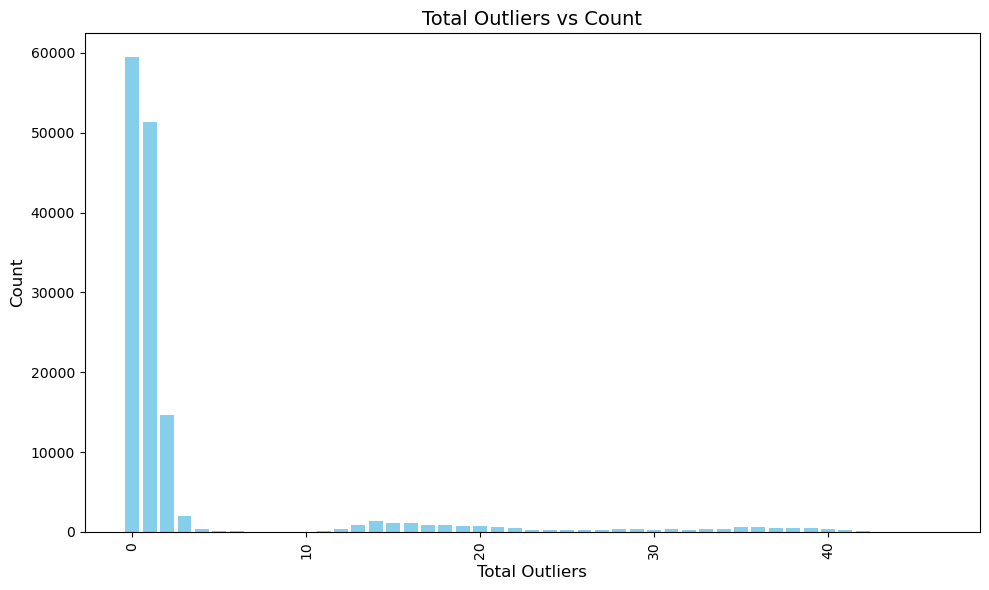

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

pandas_df = df_outliers.groupby("total_outliers").count().toPandas()

plt.figure(figsize=(10, 6))
plt.bar(pandas_df["total_outliers"], pandas_df['count'], color='skyblue')
plt.xlabel('Total Outliers', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Total Outliers vs Count', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [44]:
#Getting rid of the entries which have more than 10 outliers
df_outliers_until_ten = df_outliers.\
        filter(df_outliers['total_outliers']<=10) 
print(df_outliers_until_ten.count())

128192


In [45]:
columns_to_check =['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 
    'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 
    'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk']
null_counts_df = df_outliers.select([
    count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in columns_to_check
])
null_counts_df.show(truncate=False, vertical=True)

-RECORD 0--
 ls  | 0   
 st  | 0   
 rs  | 0   
 lw  | 0   
 lf  | 0   
 cf  | 0   
 rf  | 0   
 rw  | 0   
 lam | 0   
 cam | 0   
 ram | 0   
 lm  | 0   
 lcm | 0   
 cm  | 0   
 rcm | 0   
 rm  | 0   
 lwb | 0   
 ldm | 0   
 cdm | 0   
 rdm | 0   
 rwb | 0   
 lb  | 0   
 lcb | 0   
 cb  | 0   
 rcb | 0   
 rb  | 0   
 gk  | 0   



#### Getting rid of 16114 entries (11.17% of the data) as they had more than 10 outliers (Bye bye Messi)

## Handling correlations

In [46]:
int_columns = [col for col, dtype in df_outliers_until_ten.dtypes if dtype == 'int']
df_int = df_outliers_until_ten.select(*int_columns)
df_int  = df_int.drop("overall","Data_Year", 'total_outliers' )

In [47]:
import seaborn as sns
correlation_matrix = df_int.toPandas().corr()

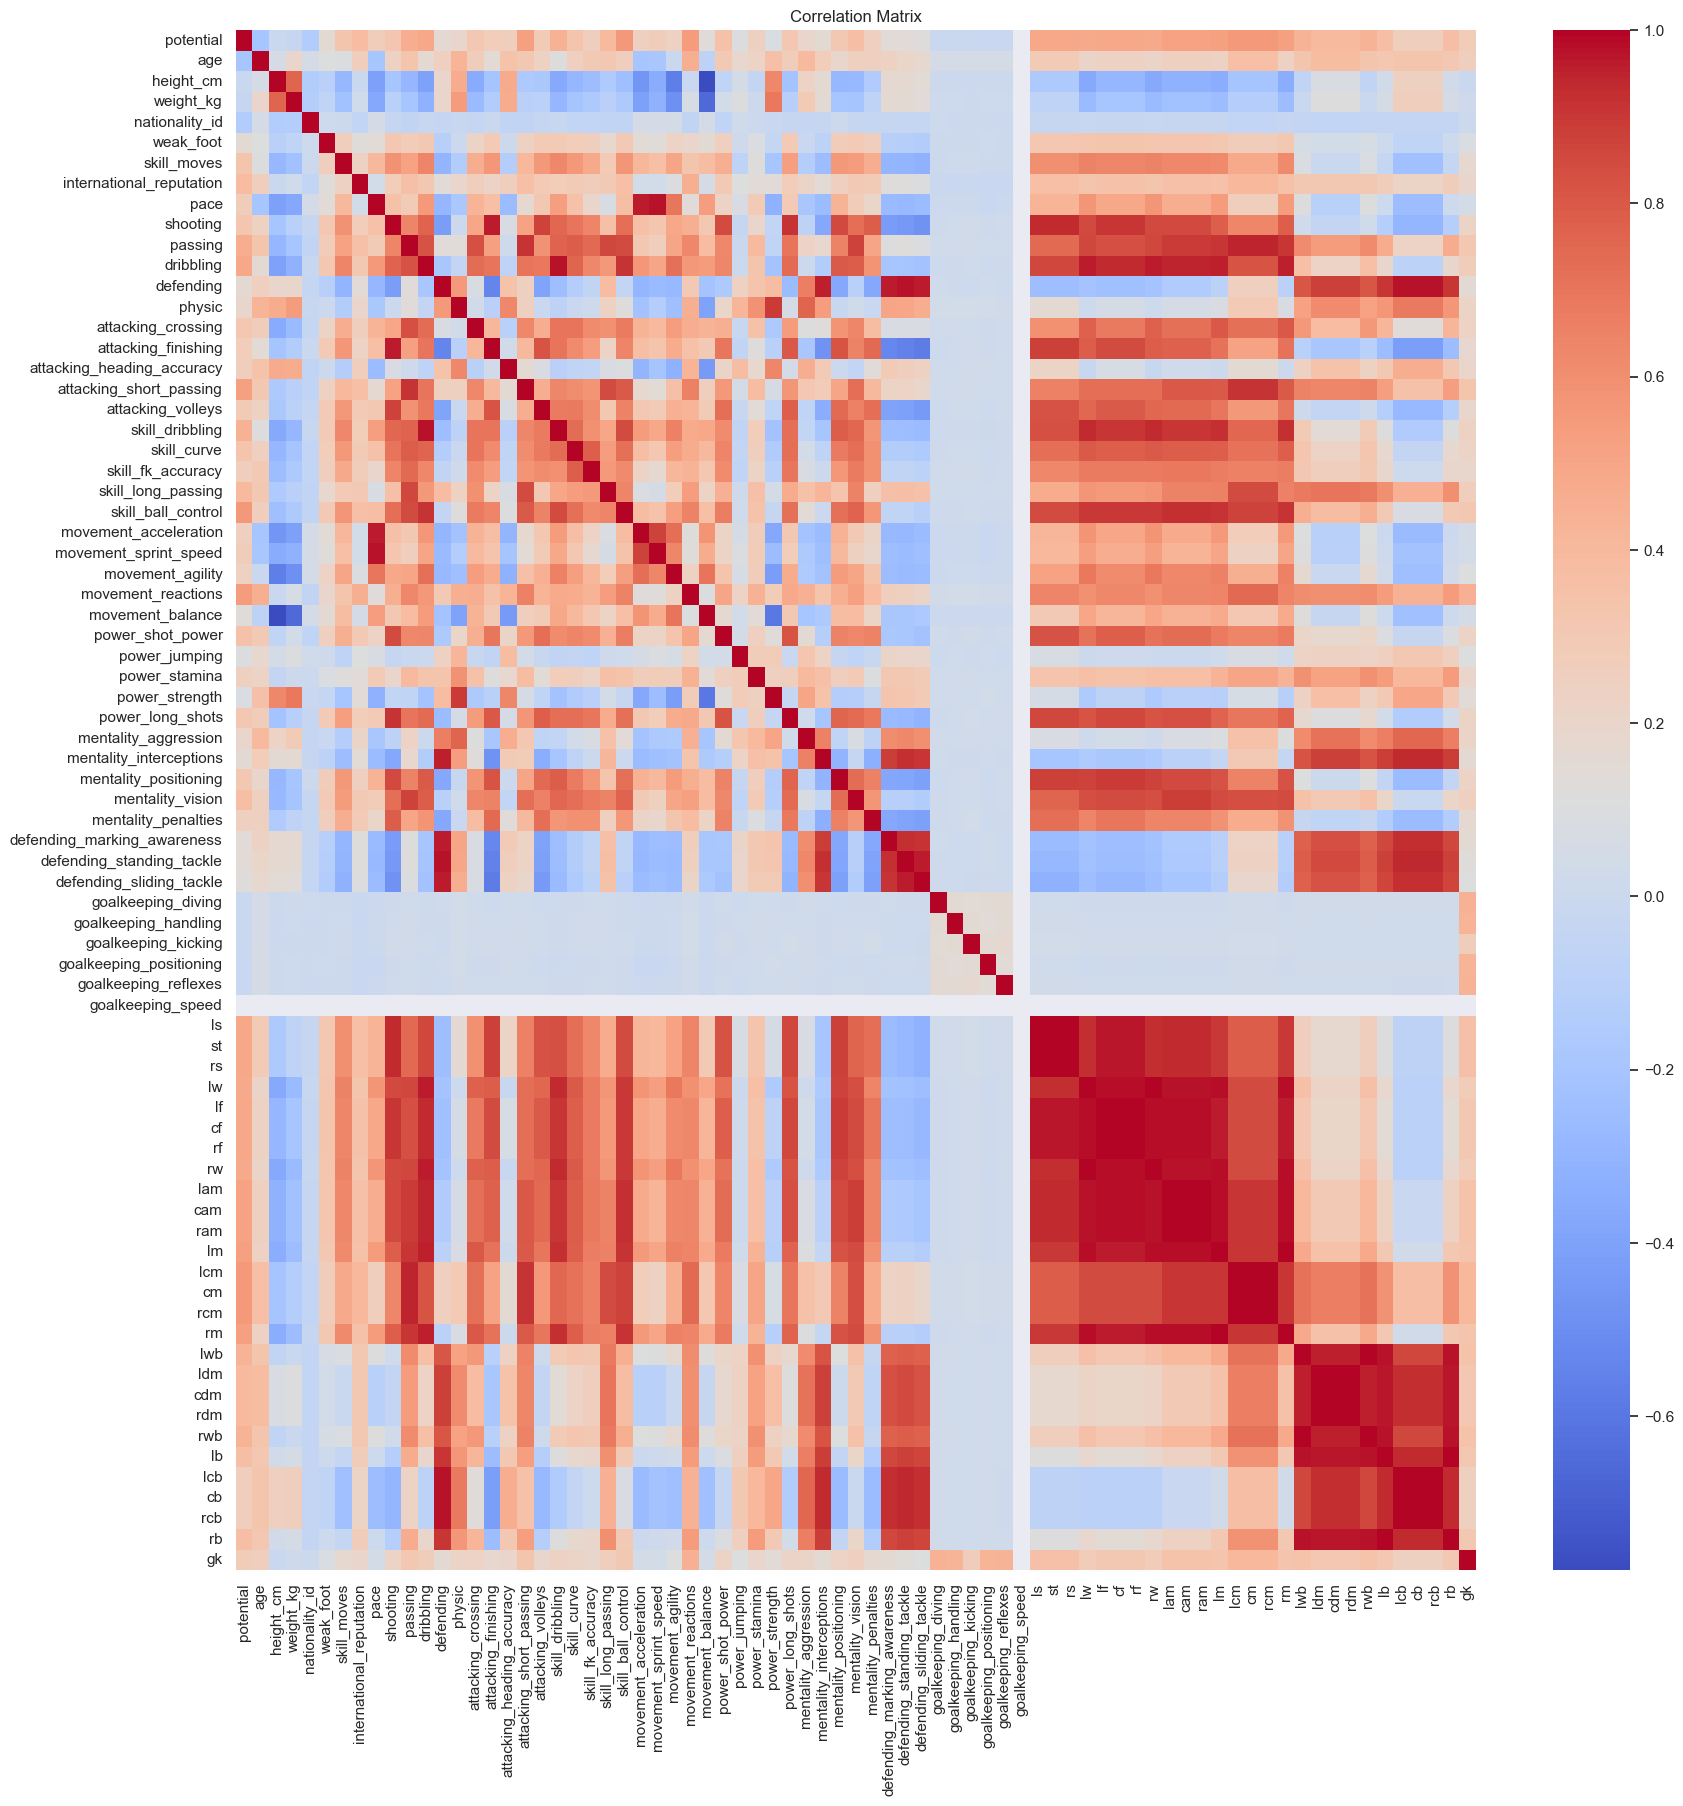

In [48]:
plt.figure(figsize=(20,20))
sns.set(font_scale=1)  # Font size
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')  # annot=False removes text
plt.title('Correlation Matrix')
plt.show()

### Combining Columns to reduce features

In [49]:
#As ls , rs, lf etc (attacking attributes) are highly correlated with each other, averaging them out to to keep one row. Doing the same for
# defensive attributes 'lwb','cdm' etc
from pyspark.sql import functions as F
columns_to_average = ['lwb', 'cdm', 'rdm', 'rwb','lb','lcb','cb','rcb','rb', 
                      'defending',
                      'defending_marking_awareness',
                      'defending_standing_tackle',
                      'defending_sliding_tackle']  # Columns showing defensive strength

df_handled_corr = df_outliers_until_ten.withColumn(
    'defensive_mean', 
    (F.col('lwb') + F.col('cdm') + F.col('rdm') + F.col('rwb') + 
     F.col('lb')+ F.col('lcb')+ F.col('cb')+ F.col('rcb') +  F.col('rb') +
     F.col('defending') + 
     F.col('defending_marking_awareness') + 
     F.col('defending_standing_tackle') + 
     F.col('defending_sliding_tackle'))/len(columns_to_average)
)
df_handled_corr = df_handled_corr.drop(*columns_to_average)



In [50]:
#Columns showing offensive strength
offensive_columns = [ 'ls', 'st', 'rs','lw','lf', 'cf','rf','rw','lam','cam','ram', 'lm','lcm','cm','rcm','rm']
df_handled_corr = df_handled_corr.withColumn(
    'offensive_mean', 
    (F.col('ls') + F.col('st') + F.col('rs') + F.col('lw') + F.col('lf')+ F.col('cf')+ F.col('rf')+ F.col('rw') +  F.col('lam')+ F.col('cam')+ F.col('ram')+ F.col('lm')+ F.col('lcm') +  F.col('cm')) / 14 
)
df_handled_corr = df_handled_corr.drop(*offensive_columns)

In [51]:
df_handled_corr = df_handled_corr.drop('total_outliers').drop('work_rate').drop('gk').drop('ldm')

In [52]:
columns_to_check =["age", "height_cm", "weight_kg", "pace", "shooting", "passing", 
                                      "dribbling", "physic", "attacking_crossing", 
                                      "attacking_finishing", "attacking_heading_accuracy", 
                                      "attacking_short_passing", "attacking_volleys", "skill_dribbling", 
                                      "skill_curve", "skill_fk_accuracy", "skill_long_passing", 
                                      "skill_ball_control", "movement_acceleration", 
                                      "movement_sprint_speed", "movement_agility", "movement_reactions", 
                                      "movement_balance", "power_shot_power", "power_jumping", 
                                      "power_stamina", "power_strength", "power_long_shots", 
                                      "mentality_aggression", "mentality_interceptions", 
                                      "mentality_positioning", "mentality_vision", "mentality_penalties", 
                                      "goalkeeping_diving", 
                                      "goalkeeping_handling", "goalkeeping_kicking", 
                                      "goalkeeping_positioning", "goalkeeping_reflexes", 
                                      "goalkeeping_speed", "Gender", "body_type","defensive_mean","offensive_mean"]
null_counts_df = df_handled_corr.select([
    count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in columns_to_check
])
null_counts_df.show(truncate=False, vertical=True)

-RECORD 0-------------------------
 age                        | 0   
 height_cm                  | 0   
 weight_kg                  | 0   
 pace                       | 0   
 shooting                   | 0   
 passing                    | 0   
 dribbling                  | 0   
 physic                     | 0   
 attacking_crossing         | 0   
 attacking_finishing        | 0   
 attacking_heading_accuracy | 0   
 attacking_short_passing    | 0   
 attacking_volleys          | 0   
 skill_dribbling            | 0   
 skill_curve                | 0   
 skill_fk_accuracy          | 0   
 skill_long_passing         | 0   
 skill_ball_control         | 0   
 movement_acceleration      | 0   
 movement_sprint_speed      | 0   
 movement_agility           | 0   
 movement_reactions         | 0   
 movement_balance           | 0   
 power_shot_power           | 0   
 power_jumping              | 0   
 power_stamina              | 0   
 power_strength             | 0   
 power_long_shots   

### Check Correlation Matrix again

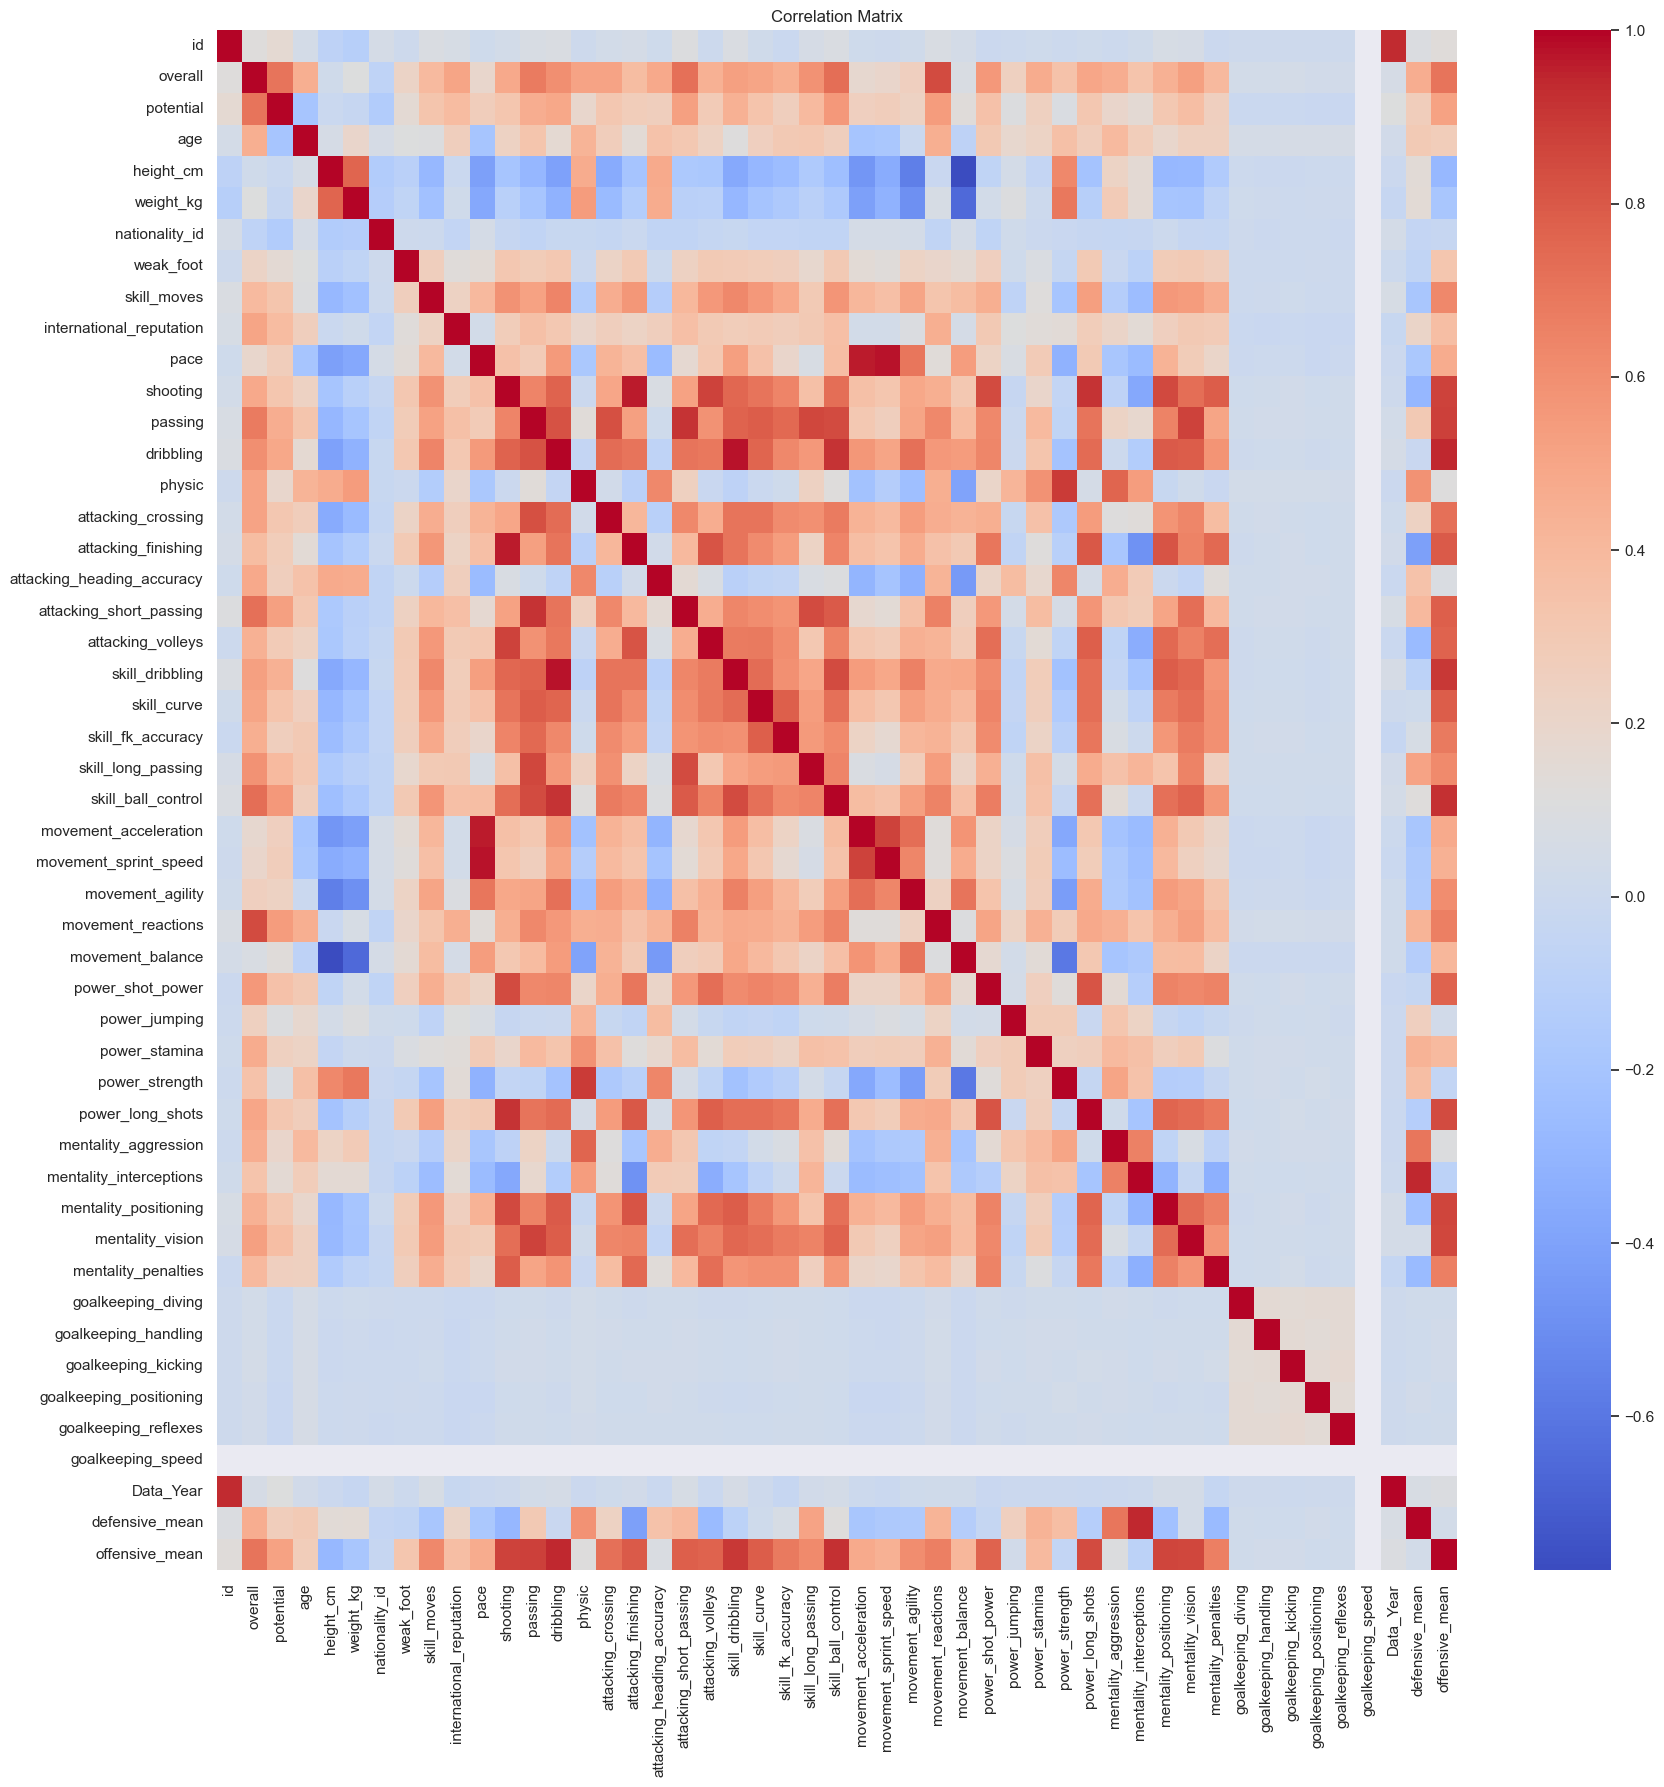

In [53]:
correlation_matrix = df_handled_corr.toPandas().corr()
plt.figure(figsize=(20,20))
sns.set(font_scale=1)  # Font size
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')  # annot=False removes text
plt.title('Correlation Matrix')
plt.show()

In [54]:
df_handled_corr.count()

128192

## Handling Binary, Ordinal and Nominal Variables

In [55]:
#Preferred foot and Gender are the only two binary variables, which are already handled in the beginning. Casting them
df_handled_binary = (df_handled_corr.withColumn("Gender_new", \
                    df_handled_corr["Gender"] \
                    .cast("integer")).drop("Gender").withColumn("preferred_foot_new", df_handled_corr['preferred_foot'].cast('integer')).drop('preferred_foot'))

In [56]:
# Get distinct values from 'body_type' column
distinct_body_types = df_handled_binary.select(collect_set("body_type")).first()[0]
print(distinct_body_types)
df_handled_binary = df_handled_binary.withColumn("body_type", when(df_handled_binary["body_type"] == "", "Normal").otherwise(df_handled_binary["body_type"]))


['Stocky', 'Lean', '', 'Normal']


In [57]:


# Indexing and encoding categorical features
indexers = [
    StringIndexer(inputCol="body_type", outputCol="body_type_index")
]

encoders = [
    OneHotEncoder(inputCols=["body_type_index"], 
                  outputCols=["body_type_encoded"])
]

# Assembling all features into a single vector
assembler = VectorAssembler(inputCols=["age", "height_cm", "weight_kg", "pace", "shooting", "passing", 
                                      "dribbling", "physic", "attacking_crossing", 
                                      "attacking_finishing", "attacking_heading_accuracy", 
                                      "attacking_short_passing", "attacking_volleys", "skill_dribbling", 
                                      "skill_curve", "skill_fk_accuracy", "skill_long_passing", 
                                      "skill_ball_control", "movement_acceleration", 
                                      "movement_sprint_speed", "movement_agility", "movement_reactions", 
                                      "movement_balance", "power_shot_power", "power_jumping", 
                                      "power_stamina", "power_strength", "power_long_shots", 
                                      "mentality_aggression", "mentality_interceptions", 
                                      "mentality_positioning", "mentality_vision", "mentality_penalties",
                                       "goalkeeping_diving", 
                                      "goalkeeping_handling", "goalkeeping_kicking", 
                                      "goalkeeping_positioning", "goalkeeping_reflexes", 
                                      "goalkeeping_speed","Gender_new", "body_type_encoded"], 
                          outputCol="features")

# Scaling features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Stage where we remove all other columns


# Model setup (e.g., RandomForestRegressor for regression task)


In [58]:
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler])

# Fitting the pipeline model
pipeline_model = pipeline.fit(df_handled_binary)

# Transforming data

df_encoded = pipeline_model.transform(df_handled_binary)

In [59]:
df_encoded.select("short_name", "overall", "scaled_features").show(6, vertical=True)

-RECORD 0-------------------------------
 short_name      | Z. Ibrahimović       
 overall         | 90                   
 scaled_features | [7.07346782772735... 
-RECORD 1-------------------------------
 short_name      | R. van Persie        
 overall         | 88                   
 scaled_features | [6.63137608849439... 
-RECORD 2-------------------------------
 short_name      | B. Schweinsteiger    
 overall         | 88                   
 scaled_features | [6.41033021887791... 
-RECORD 3-------------------------------
 short_name      | F. Ribéry            
 overall         | 88                   
 scaled_features | [6.85242195811087... 
-RECORD 4-------------------------------
 short_name      | Falcao               
 overall         | 88                   
 scaled_features | [6.18928434926143... 
-RECORD 5-------------------------------
 short_name      | E. Hazard            
 overall         | 88                   
 scaled_features | [5.08405500117903... 
only showing top

In [60]:
df_encoded.show(1, vertical = True)

-RECORD 0------------------------------------------
 id                         | 3                    
 short_name                 | Z. Ibrahimović       
 long_name                  | Zlatan Ibrahimović   
 overall                    | 90                   
 potential                  | 90                   
 age                        | 32                   
 height_cm                  | 195                  
 weight_kg                  | 95                   
 nationality_id             | 46                   
 weak_foot                  | 4                    
 skill_moves                | 4                    
 international_reputation   | 5                    
 body_type                  | Normal               
 pace                       | 76                   
 shooting                   | 91                   
 passing                    | 81                   
 dribbling                  | 86                   
 physic                     | 86                   
 attacking_c

In [61]:
df_readyToModel = df_encoded.select("scaled_features","overall")
df_readyToModel.show(1, vertical = True)

-RECORD 0-------------------------------
 scaled_features | [7.07346782772735... 
 overall         | 90                   
only showing top 1 row



In [62]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

trainData, testData = df_readyToModel.randomSplit([0.8, 0.2], seed = 12)

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(labelCol="overall", featuresCol="scaled_features", seed = 12)

# Set up the hyperparameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [20, 50, 100])      # Number of trees in the forest
             .addGrid(rf.maxDepth, [5, 10, 15])         # Maximum depth of each tree
             .addGrid(rf.maxBins, [16, 32, 64])         # Number of bins for splitting
             .build())

# Define an evaluator for classification, using accuracy as a metric
evaluator = MulticlassClassificationEvaluator(labelCol="overall", predictionCol="prediction", metricName="accuracy")

# Set up CrossValidator
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # Use 3-fold cross-validation

# Fit the model using the training data
cvModel = crossval.fit(trainData)

# Display the best model's parameters and accuracy
bestModel = cvModel.bestModel
print(f"Best numTrees: {bestModel.getNumTrees}")
print(f"Best maxDepth: {bestModel.getMaxDepth()}")
print(f"Best maxBins: {bestModel.getMaxBins()}")
print(f"Best accuracy: {evaluator.evaluate(bestModel.transform(testData))}")
